# El bandidos

**Multi-armed bandits** is special case of reinforcement learning. The main problem is how to balance exploitation and exploration. Exploit too much then you might miss the best action. Explore too much then in the long run your accumulative reward will be lower.

Here's how to play it. There are k number of slot machine, each slot machine give reward from some unknown distribution. At each turn, you must pick one slot to turn. The goal is to maximize sum of reward into some finite time horizon (like 100 turns).

In this notebook we will simulating several bandit algorithm, starting from random, e-greedy, and upper confidence bound.

<img src='resource/rl/slot.jpg' style='width: 91px' align='left'/>
<img src='resource/rl/slot.jpg' style="width: 91px" align='left'/>
<img src='resource/rl/slot.jpg' style="width: 91px" align='left'/>
<img src='resource/rl/slot.jpg' style="width: 91px" align='left'/>
<img src='resource/rl/slot.jpg' style="width: 91px" align='left'/>
<img src='resource/rl/slot.jpg' style="width: 91px" align='left'/>
<img src='resource/rl/slot.jpg' style="width: 91px" align='left'/>
<img src='resource/rl/slot.jpg' style="width: 91px" align='left'/>
<img src='resource/rl/slot.jpg' style="width: 91px" align='left'/>
<img src='resource/rl/slot.jpg' style="width: 91px" align='left'/>

## The test case
First, we generate 2000 test case of 10-armed bandits problem. The performance of each algorithm then can be calculated by the sum of average of all experiments. In other words, we averaged the reward from each different test bed for each timesteps. The total reward is the area size below the curve

In [1]:
import time
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (20, 8)
sns.set_style('darkgrid')

In [2]:
n_testbed = 2000
n_k = 10
qstars = np.zeros((n_testbed, n_k))

np.random.seed(0)
for i in range(n_testbed):
    for k in range(n_k):
        qstars[i, k] = np.random.normal(0, 1)

/Users/muhammadtawakal/workspace/lingkungan_kerja/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


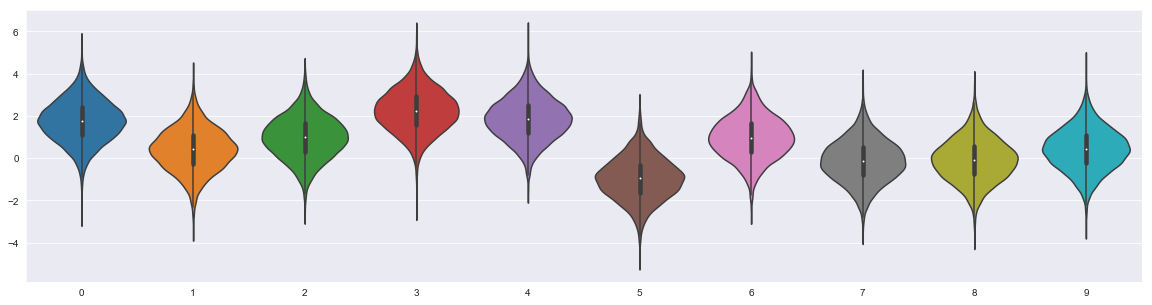

In [3]:
sample_size = 10000

plt.figure(figsize=(20, 5))
samples = np.zeros((n_k, sample_size))
for i in range(n_k):
    samples[i, :] = np.random.normal(qstars[0, i], 1, size=sample_size)
    
df = pd.DataFrame(samples.transpose())
sns.violinplot(data=df);


The first strategy that we will try is simple. We will then compare it to totally random bandit

In [4]:
class GreedyBandit():
    
    def __init__(self, epsilon):
        self.epsilon = epsilon
        
    def run(self, qstar, timestep):
        
        epsilon = self.epsilon
        k = len(qstar)
        Q = np.zeros(k)
        N = np.zeros(k)
        rewards = np.zeros(timestep)
        
        for t in range(timestep):
            
            if np.random.uniform() > epsilon:
                a = Q.argmax()
            else:
                a = np.random.randint(k)
            
            r = np.random.normal(qstar[a], 1)
            N[a] += 1
            Q[a] = Q[a] + (r - Q[a])/N[a]
            
            rewards[t] = r
        
        return rewards

In [5]:
def simulate(qstars, bandit, timestep):
    
    n = len(qstars)
    
    avg_rewards = np.zeros(timestep)
    for i in range(n):
        avg_rewards += bandit.run(qstars[i, :], timestep)
    
    return avg_rewards / n


def plot(rewards, label):
    plt.plot(rewards, label=label+' total: '+str(rewards.sum())[:9])
    plt.xlabel('timestep')
    plt.ylabel('average reward')
    plt.legend()

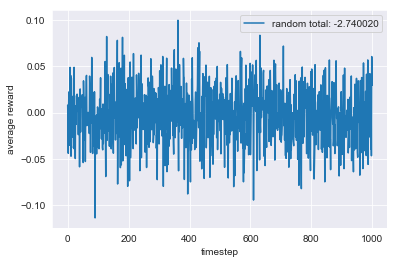

In [6]:
bandit1 = GreedyBandit(1)
reward1 = simulate(qstars, bandit1, 1000)
plot(reward1, 'random')

The second strategy is fully greedy

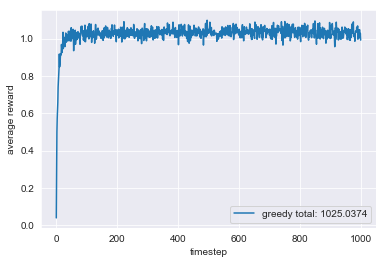

In [7]:
bandit2 = GreedyBandit(0)
reward2 = simulate(qstars, bandit2, 1000)
plot(reward2, 'greedy')

Now we balance exploitation with exploration using epsilon

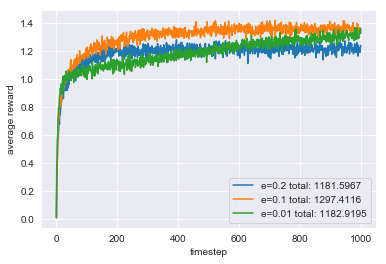

In [8]:
bandit3 = GreedyBandit(0.2)
reward3 = simulate(qstars, bandit3, 1000)
plot(reward3, 'e=0.2')

bandit4 = GreedyBandit(0.1)
reward4 = simulate(qstars, bandit4, 1000)
plot(reward4, 'e=0.1')

bandit5 = GreedyBandit(0.01)
reward5 = simulate(qstars, bandit5, 1000)
plot(reward5, 'e=0.01')

#### Upper Confidence Bound

However, the slot is picked randomly. The intuition is, if two given same reward, then we picked the one that has been picked less because we are still uncertain about its potential
The derivation is out of scope of this notebook. You can refer to this post by jeremy kun

In [9]:
class UCBBandit():
    
    def __init__(self):
        pass
    
    def run(self, qstar, timestep):
        
        k = len(qstar)
        
        Q = np.array([np.random.normal(qstar[i], 1) for i in range(k)])
        N = np.ones(k)
        
        rewards = np.zeros(timestep)
        rewards[:k] = Q
        for t in range(k, timestep):
            
            At = np.array([x + math.sqrt(math.log(t)/N[a]) for (a, x) in enumerate(Q)])
            a = At.argmax()
            r = np.random.normal(qstar[a], 1)
            
            N[a] += 1
            Q[a] = Q[a] + (r - Q[a]) / N[a]
            rewards[t] = r
        
        return rewards        

In [10]:
def ucb_bandit(qstar, c):
    """Upper confidence bound"""
    
    k = len(qstar)
    Q = np.zeros(k)
    N = np.ones(k)
    rewards = np.zeros(1000)
    for t in range(1000):
        
        At = np.array([x + c*(math.sqrt(math.log(t+1)/N[a])) for (a, x) in enumerate(Q)])
        a = At.argmax()
                
        r = np.random.normal(qstar[a], 1)
        N[a] += 1
        Q[a] = Q[a] + (r - Q[a])/N[a]
        
        rewards[t] = r
        
    return rewards

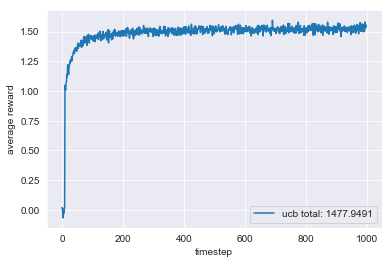

In [11]:
ucb = UCBBandit()
reward6 = simulate(qstars, ucb, 1000)
plot(reward6, 'ucb')

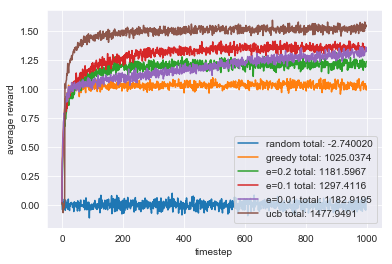

In [12]:
# Here's the full comparison on all algorithms
plot(reward1, 'random')
plot(reward2, 'greedy')
plot(reward3, 'e=0.2')
plot(reward4, 'e=0.1')
plot(reward5, 'e=0.01')
plot(reward6, 'ucb')

# Other bandits (next time)

## Contextual bandits
Now, each turn you will given some kind of context. This context might change the way the reward is given. For example, in context A, the bandit slots rewards is secretly reversed.

We can run this as N k-armed bandits. However, this is costly. There is a better cost function for this problem. Mainly EXP4 and linear bandits.

## Adversarial bandits
Now you relax the reward generation function assumption a bit and paranoidly imagine there is a puppetmaster that will try to give you worst possible outcome. Now you must keep your guard all the time.